In [170]:
import shapefile
from shapely.geometry import Polygon
from shapely.geometry import Point
import numpy as np
import os 
from couchdb.design import ViewDefinition
import couchdb
from datetime import datetime
import pytz
import pandas as pd
import statsmodels.formula.api as sm

In [171]:
#PATH = "./data/mortality/shp/feededc1-8785-49a3-b5fb-da9678c4111b.prj"
#PATH2 = "./data/mortality/csv/prematureMortality.csv"
PATH='/home/ubuntu/data/datas.prj'
PATH2='/home/ubuntu/datas.csv'

sf = shapefile.Reader(PATH)

shape = sf.shapes()
len(shape)

66

In [172]:
# pmD is the data frame read from csv# pmD i
#data = pd.read_csv('file1.csv', error_bad_lines=False)
pmD = pd.read_csv(PATH2)

In [173]:
pmD = pmD.replace(r'null', np.nan, regex=True)
pmD

,sa3_code16,sa3_name16,female_divorced,female_separated,male_divorced,male_separated
0,20101,Ballarat,2011,1103,1260,764
1,20102,Creswick - Daylesford - Ballan,486,195,360,160
2,20103,Maryborough - Pyrenees,441,228,341,200
3,20201,Bendigo,1880,997,1147,718
4,20202,Heathcote - Castlemaine - Kyneton,757,379,550,292
5,20203,Loddon - Elmore,155,67,152,87
6,20301,Barwon - West,273,154,201,135
7,20302,Geelong,3513,1871,2326,1355
8,20303,Surf Coast - Bellarine Peninsula,1127,580,697,427
9,20401,Upper Goulburn Valley,923,522,716,391


In [174]:
# extract from data frame
area_code = pmD.iloc[:,0]
area_name = pmD.iloc[:,1]
female_divorce = pmD.iloc[:,2]
female_sep = pmD.iloc[:,3]
male_divorce = pmD.iloc[:,4]
male_sep = pmD.iloc[:,5]

In [175]:
zero = [0]*66

In [176]:
#record of coordinates
record = sf.shapeRecords()

In [177]:
record[0].shape.points
len(record)

66

In [178]:
rawCoord = []
for i in range(len(record)):
    rawCoord.append(Polygon(record[i].shape.points))
rawCoord[0:2]

In [179]:
LGAcoord = dict(zip(area_code,rawCoord))

In [180]:
# Connect to sc_tweets couchDB and retrieve the Coordinate values along with sentiment analysis
user = 'admin'
password = 'admin'
try:
    couch = couchdb.Server('http://%s:%s@115.146.95.146:5984/' % (user, password))
    db_sc_tweets = couch['sc_tweets']
except:
    print('Connection Failed')
    
# Connect to sc_tweets couchDB and retrieve the Coordinate values along with sentiment analysis
scGen = []
for row in db_sc_tweets.view('_design/DocsWithCoordinates/_view/CoordinatesNSentiments'): 
    coordinates = row.key
    score = row.value
    scGen.append([coordinates,score])


In [181]:
print(scGen[0])

[[136.0151665, -26.441329000000003], 0]


In [182]:
areaDictUC = dict(zip(area_code,zero))
for tw in range(len(scGen)):
    for area in LGAcoord:
        if LGAcoord[area].contains(Point(scGen[tw][0][0],scGen[tw][0][1])):
            areaDictUC[area] += 1

In [183]:
urbanCulture = np.array([ v for v in areaDictUC.values() ])

In [184]:
urbanCulture

array([ 1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  3,  1,  3,  0,  0,  0,  1,  0, 44,  0,  0,  0,  0,  1,  0,
        0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        0,  0,  0,  0,  0,  1,  1,  2,  0,  0,  0,  0,  0,  0,  0])

In [185]:
# Connect to sentiment_tweets couchDB and retrieve the Coordinate values along with sentiment scores
stressGen = []
try:
    db_sentiment_tweetsets = couch['sentiment_tweets']
    for row in db_sentiment_tweets.view('_design/DocsWithCoordinates/_view/CoordinatesNSentiments'): 
        coordinates = row.key
        score = row.value
        stressGen.append([coordinates,score])
except:
    print('Connection Failed') 

In [186]:
print(stressGen[0])

[[135.0021463034835, -32.02937474330305], 0.7263]


In [187]:
# extract negative tweets
negative = 0
negTweets = []
for i in range(len(stressGen)):
    if stressGen[i][1] <= 0:
        #print(stressGen[i])
        negTweets.append(stressGen[i][0])
        negative += 1

In [188]:
## extract positive tweets
positive = 0
posTweets = []
for i in range(len(stressGen)):
    if stressGen[i][1] > 0:
        posTweets.append(stressGen[i][0])
        positive += 1

In [189]:
# prepare dictionary
areaDictNegSent = dict(zip(area_code,zero))
areaDictPosSent = dict(zip(area_code,zero))

In [190]:
print(positive)
print(negative)

23427
24594


In [191]:
for tw in range(len(negTweets)):
    for area in LGAcoord:
        if LGAcoord[area].contains(Point(negTweets[tw][0],negTweets[tw][1])):
            areaDictNegSent[area] += 1

In [192]:
for tw in range(len(posTweets)):
    for area in LGAcoord:
        if LGAcoord[area].contains(Point(posTweets[tw][0],posTweets[tw][1])):
            areaDictPosSent[area] += 1

In [193]:
list_Negvalues = [ v for v in areaDictNegSent.values() ]
list_Posvalues = [ v for v in areaDictPosSent.values() ]

# convert list to numpy array
negSentiment = np.array(list_Negvalues)
posSentiment = np.array(list_Posvalues)

In [194]:
negSentiment


array([ 129,   38,   23,    2,   11,    1,   32,    3,    2,    5,    3,
         49,   19,    1,    5,    0,    3,    1,    2,  358,   61,   65,
          0,    1,    1,   36,    5, 6913,   24,    3,    1,   16,   22,
         73,   12,    5,   11,   55,   64,    0,   13,    4,    4,    3,
          0,    2,    4,   11,   27,  123,   29,    0,    6,    2,    1,
          1,   21,   14,   14,    5,    5,    3,   58,    5,   16,   12])

In [195]:
posSentiment

array([ 102,   27,    9,    0,   12,    1,   25,    7,    1,   13,    5,
         59,   18,    6,    3,    1,    3,    4,    3,  347,   50,   61,
          2,    1,    5,   30,    5, 6496,   10,   12,    5,   19,   15,
         75,   17,    5,   15,   66,   60,    0,    9,    1,    2,    7,
          0,    2,    2,   10,   26,   90,   24,    0,    3,    0,    4,
          1,   27,   29,   13,    4,    8,    7,   70,   10,   22,   14])

In [196]:
pmfDivorce = np.array(female_divorce, dtype = np.float)
pmfSeparation = np.array(female_sep, dtype = np.float)

pmmDivorce = np.array(male_divorce, dtype = np.float)
pmmSeparation = np.array(male_sep, dtype = np.float)

pmDivorce=pmfDivorce + pmmDivorce
pmSeparation=pmfSeparation + pmmSeparation

In [197]:
df = pd.DataFrame({"pmDivorce": pmDivorce ,"pmSeparation": pmSeparation , 
                   "negSentiment": negSentiment, "posSentiment": posSentiment, 
                   "urbanCulture":urbanCulture, "area_code":area_code, 
                   "area_name":area_name})
df[25:76] # data for regressions

,area_code,area_name,negSentiment,pmDivorce,pmSeparation,posSentiment,urbanCulture
25,20801,Bayside,36,2202.0,955.0,30,1
26,20902,Darebin - North,5,2783.0,1315.0,5,0
27,20903,Nillumbik - Kinglake,6913,1487.0,788.0,6496,44
28,20606,Stonnington - West,24,1749.0,728.0,10,0
29,20607,Yarra,3,2774.0,1157.0,12,0
30,20904,Whittlesea - Wallan,1,6425.0,3927.0,5,0
31,21001,Keilor,16,1623.0,794.0,19,0
32,21002,Macedon Ranges,22,815.0,415.0,15,1
33,20802,Glen Eira,73,3560.0,1559.0,75,0
34,20803,Kingston,12,3671.0,1744.0,17,0


In [198]:
model = sm.ols(formula="pmDivorce ~ negSentiment + posSentiment + urbanCulture", data=df, missing = 'drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              pmDivorce   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.3968
Date:                Wed, 09 May 2018   Prob (F-statistic):              0.756
Time:                        07:15:41   Log-Likelihood:                -579.96
No. Observations:                  66   AIC:                             1168.
Df Residuals:                      62   BIC:                             1177.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2553.7634    212.870     11.997   

In [ ]:
# Interpretation example,
# For every one increase in a positive tweet count, you can expect on average 7.594 decrease,
# on average, in average annual rate of divorce per 100,000 people
#
# For every one increase in a negative tweet count, you can expect on average 4.979 increase,
# on average, in average annual rate of divorce per 100,000 people

In [199]:
model = sm.ols(formula="pmSeparation ~ negSentiment + posSentiment + urbanCulture", data=df, missing = 'drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           pmSeparation   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.1661
Date:                Wed, 09 May 2018   Prob (F-statistic):              0.919
Time:                        07:15:41   Log-Likelihood:                -544.71
No. Observations:                  66   AIC:                             1097.
Df Residuals:                      62   BIC:                             1106.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1363.5224    124.768     10.928   

In [ ]:
# Interpretation example,
#
# For every one increase in a positive tweet count, you can expect on average 1.062 decrease,
# on average, in average annual rate of separation per 100,000 people
#
# For every one increase in a negative tweet count, you can expect on average 0.4534 increase,
# on average, in average annual rate of separation per 100,000 people

In [200]:
import scipy as sp
from numpy import *

In [220]:
sp.stats.pearsonr(posSentiment,pmDivorce)

#t=np.corrcoef(posSentiment,pmDivorce)
#print(t)

(-0.0851075560805669, 0.49685866440662274)

In [202]:
sp.stats.pearsonr(posSentiment,pmSeparation)

(-0.07949033778139336, 0.5257878589729532)

In [203]:
sentimentDictExport = {"negativeSentiment":list(negSentiment), "positiveSentiment":list(posSentiment), "area_code":list(area_code), 
                          "area_name": list(area_name)}

In [204]:
rowList = []
for row in range(len(df)):
    rowList.append(list(list(df.iloc[[row]].values)[0]))

In [205]:
area_codeS = list(map(str, area_code))
#area_codeS
dataVisualize = dict(zip(area_codeS, rowList))
#dataVisualize

In [206]:
dataVisualize['fieldname'] = list(df)
# dataVisualize

In [207]:
import json
# for visualization on JavaScript front end
with open('visualizeSentiment.json', 'w') as fp:
    json.dump(dataVisualize, fp)

In [208]:
import matplotlib.pyplot as plt

-0.04465962934812519 242.71372819291358


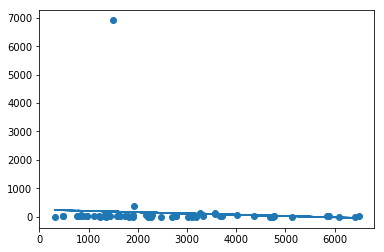

In [221]:
# graph of divroce rate vs negative sentiments
plt.figure(1)
plt.scatter(pmDivorce, negSentiment)
m, b = np.polyfit(pmDivorce,negSentiment,1)
#print(m,b)
plt.plot(pmDivorce,m*pmDivorce+b, '-')
plt.show()

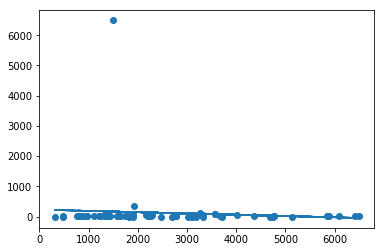

In [222]:
# graph of divroce rate vs postive sentiments
plt.figure(1)
plt.scatter(pmDivorce, posSentiment)
m, b = np.polyfit(pmDivorce,posSentiment,1)
#print(m,b)
plt.plot(pmDivorce,m*pmDivorce+b, '-')
plt.show()

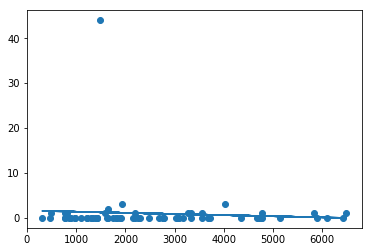

In [223]:
# graph of divroce rate vs urban pop culture
plt.figure(1)
plt.scatter(pmDivorce, urbanCulture)
m, b = np.polyfit(pmDivorce,urbanCulture,1)
#print(m,b)
plt.plot(pmDivorce,m*pmDivorce+b, '-')
plt.show()

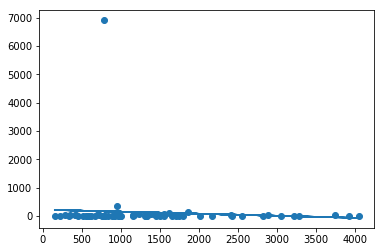

In [224]:
# graph of separation rate vs negative sentiments
plt.figure(1)
plt.scatter(pmSeparation, negSentiment)
m, b = np.polyfit(pmSeparation,negSentiment,1)
#print(m,b)
plt.plot(pmSeparation,m*pmSeparation+b, '-')
plt.show()

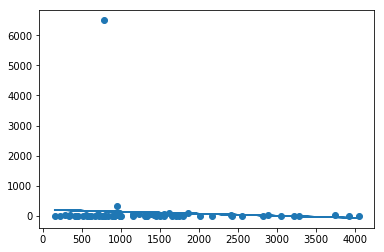

In [225]:
# graph of separation rate vs positive sentiments
plt.figure(1)
plt.scatter(pmSeparation, posSentiment)
m, b = np.polyfit(pmSeparation,posSentiment,1)
#print(m,b)
plt.plot(pmSeparation,m*pmSeparation+b, '-')
plt.show()

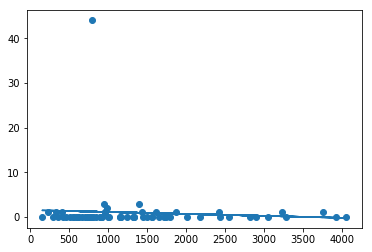

In [226]:
# graph of separation rate vs urban pop culture
plt.figure(1)
plt.scatter(pmSeparation, urbanCulture)
m, b = np.polyfit(pmSeparation,urbanCulture,1)
#print(m,b)
plt.plot(pmSeparation,m*pmSeparation+b, '-')
plt.show()

In [210]:
df

,area_code,area_name,negSentiment,pmDivorce,pmSeparation,posSentiment,urbanCulture
0,20101,Ballarat,129,3271.0,1867.0,102,1
1,20102,Creswick - Daylesford - Ballan,38,846.0,355.0,27,0
2,20103,Maryborough - Pyrenees,23,782.0,428.0,9,0
3,20201,Bendigo,2,3027.0,1715.0,0,0
4,20202,Heathcote - Castlemaine - Kyneton,11,1307.0,671.0,12,0
5,20203,Loddon - Elmore,1,307.0,154.0,1,0
6,20301,Barwon - West,32,474.0,289.0,25,0
7,20302,Geelong,3,5839.0,3226.0,7,1
8,20303,Surf Coast - Bellarine Peninsula,2,1824.0,1007.0,1,0
9,20401,Upper Goulburn Valley,5,1639.0,913.0,13,0


In [227]:
divorceVsNeg = []
for i in range(len(pmDivorce)):
    divorceVsNeg.append([list(negSentiment)[i],list(pmDivorce)[i]])
# divorcevsNeg # for export to JavaScript

In [212]:
divorceVsPos = []
for i in range(len(pmDivorce)):
    divorceVsPos.append([list(posSentiment)[i],list(pmDivorce)[i]])
# divorcevsPos # for export to JavaScript

In [213]:
divorceVsUrban = []
for i in range(len(pmDivorce)):
    divorceVsUrban.append([list(urbanCulture)[i],list(pmDivorce)[i]])
# divorcevsUrban # for export to JavaScript

In [214]:
sepVsNeg = []
for i in range(len(pmSeparation)):
    sepVsNeg.append([list(negSentiment)[i],list(pmSeparation)[i]])
# sepVsNeg # for export to JavaScript

In [215]:
sepVsPos = []
for i in range(len(pmSeparation)):
    sepVsPos.append([list(posSentiment)[i],list(pmSeparation)[i]])
# sepVsPos # for export to JavaScript

In [216]:
sepVsUrban = []
for i in range(len(pmSeparation)):
    sepVsUrban.append([list(urbanCulture)[i],list(pmSeparation)[i]])
# sepVsUrban # for export to JavaScript